In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_operator_from_y(y, dim1B, dim2B):  
  # reshape the solution vector into 0B, 1B, 2B pieces
  #print(y)
  ptr = 0
  zero_body = y[ptr]

  ptr += 1
  #print(y[ptr:ptr+dim1B*dim1B])
  one_body = np.reshape(y[ptr:ptr+dim1B*dim1B], (dim1B, dim1B))

  ptr += dim1B*dim1B
  two_body = np.reshape(y[ptr:ptr+dim2B*dim2B], (dim2B, dim2B))

  return zero_body,one_body,two_body

Plot calculating $|H_{true}(s)-H_{ROM}(s)|$

In [3]:
inPath = "/mnt/c/Users/aryan/Documents/MSU_FRIB/IMSRG/proper_orth_decomp/"
Hfile = 0
Hopinf_file = 0
Hgalerkin_file = 0

with open(inPath+"allHs.pkl", 'rb') as fp:
    Hfile = pickle.load(fp)

with open(inPath+"allH_opinf.pkl", 'rb') as fp:
    Hopinf_file = pickle.load(fp)

with open(inPath+"allH_galerkin.pkl", 'rb') as fp:
    Hgalerkin_file = pickle.load(fp)

In [4]:
diffList_opinf = []
diffList_galerkin = []
for i, H in enumerate(Hfile):
    true_E, true_f, true_Gamma = get_operator_from_y(H, 8, 64)
    E_opinf, f_opinf, Gamma_opinf = get_operator_from_y(Hopinf_file[i], 8, 64)
    E_g, f_g, Gamma_g = get_operator_from_y(Hgalerkin_file[i], 8, 64)
    norm = true_E+np.linalg.norm(true_f, ord="fro")+np.linalg.norm(true_Gamma, ord="fro")
    opinf_diff = true_E-E_opinf+np.linalg.norm(true_f-f_opinf, ord="fro")+np.linalg.norm(true_Gamma-Gamma_opinf, ord="fro")
    galerkin_diff = true_E-E_g+np.linalg.norm(true_f-f_g, ord="fro")+np.linalg.norm(true_Gamma-Gamma_g, ord="fro")
    diffList_opinf.append(opinf_diff/norm)
    diffList_galerkin.append(galerkin_diff/norm)

Text(0.5, 1.0, 'ImTime Generator')

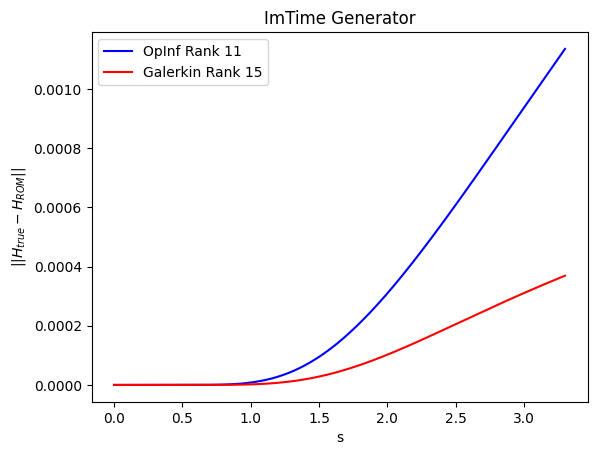

In [5]:
sList = np.linspace(0.,3.3, 330)
plt.plot(sList, diffList_opinf, label="OpInf Rank 11", color="blue")
plt.plot(sList, diffList_galerkin, label="Galerkin Rank 15", color="red")
plt.xlabel(r's')
plt.ylabel(r'$||H_{true}-H_{ROM}||$')
plt.legend()
plt.title("ImTime Generator")

In [2]:
inPath = "/mnt/c/Users/aryan/Documents/MSU_FRIB/IMSRG/proper_orth_decomp/"
direct_flows = pd.read_csv(inPath+"combined_direct.csv").iloc[:,1:]
opinf_flows = pd.read_csv(inPath+"combined_opinf.csv").iloc[:,1:]
param_flows = pd.read_csv(inPath+"combined_param.csv").iloc[:,1:]

In [3]:
direct_flows.loc[(direct_flows["g"]==0.0) & (direct_flows["b"]==-0.1), 'Ref Energy'].values[0]

1.9833806187867116

In [5]:
direct_flows

,g,b,Ref Energy,Total Steps,Total Time,RAM Usage
0,0.0,-0.1,1.983381,1.340575,162.116783,777.309570
1,0.0,0.1,1.983349,1.313986,135.358224,775.214844
2,0.0,-0.2,1.931826,2.188442,171.317679,779.926758
3,0.0,0.2,1.932287,1.927704,168.163137,780.688477
4,0.0,-0.3,1.844030,3.061108,203.667309,783.096680
...,...,...,...,...,...,...
115,0.5,0.4,1.153328,3.066409,195.866417,783.506836
116,-0.5,-0.5,2.020295,4.787883,210.809818,784.696289
117,-0.5,0.5,2.001295,3.042634,202.849146,780.978516
118,0.5,-0.5,0.895921,5.015952,217.038048,782.878906


In [4]:
opinf_coords = []
bad_opinf = []
bad_coords = []
param_coords = []
bad_param = []
for i in range(-5, 6):
    for j in range(-5, 6):
        g = i/10
        b = j/10
        if g == 0 and b == 0:
            continue
        
        E0 = direct_flows.loc[(direct_flows['g'] == g) & (direct_flows['b'] == b), 'Ref Energy'].values[0]
        E_Rom = opinf_flows.loc[(opinf_flows['g'] == g) & (opinf_flows['b'] == b), 'Ref Energy'].values[0]
        opinf_coords.append([E0, E_Rom])

        if opinf_flows.loc[(opinf_flows['g'] == g) & (opinf_flows['b'] == b), 'Total Steps'].values[0] > 15:
            bad_opinf.append([E0, E_Rom])
            bad_coords.append([g, b])
        test_mask = (param_flows['g'] == g) & (param_flows['b'] == b)
        matching_rows = param_flows.loc[test_mask, 'Ref Energy']
        if not matching_rows.empty and matching_rows.values[0]>-5:
            param_coords.append([E0, matching_rows.values[0]])
            if param_flows.loc[test_mask, 'Total Steps'].values > 15:
                bad_param.append([E0, matching_rows.values[0]])
        

In [5]:
opinf_coords = np.transpose(opinf_coords)
param_coords = np.transpose(param_coords)
bad_opinf = np.transpose(bad_opinf)
bad_param = np.transpose(bad_param)

In [6]:
from scipy.stats import linregress

In [9]:
print(len(bad_coords))

16


In [11]:
fit = linregress(opinf_coords[0], opinf_coords[1])
def lineFit(x, fit):
    return fit.slope*x+fit.intercept

x = np.linspace(0.9,2.5,1000)
y = lineFit(x, fit)
fit

LinregressResult(slope=1.0044545811716892, intercept=-0.007193477709887208, rvalue=0.9974498591002091, pvalue=3.8153384007392976e-137, stderr=0.00661634676003748, intercept_stderr=0.012111863862594056)

Text(0.5, 1.0, 'Model Comparison for Unique OpInf')

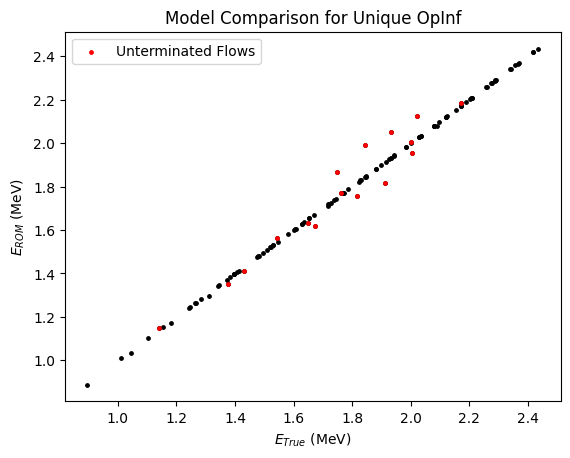

In [10]:
#plt.plot(x, y, color = "blue", linestyle='dashed')
plt.scatter(opinf_coords[0], opinf_coords[1], s=6, color = "black")
plt.scatter(bad_opinf[0], bad_opinf[1], s=6, color = "red", label = "Unterminated Flows")

plt.xlabel(r'$E_{True}$ (MeV)')
plt.ylabel(r'$E_{ROM}$ (MeV)')
plt.legend()
plt.title("Model Comparison for Unique OpInf")